# training.ipynb

This is code (in progress) for building and training the neural network.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

## Loading Files

In [2]:
# Jet type we want to use
name = 'e+mjets'

# Dataset to train and test on
dataset = h5py.File('/data/jchishol/Jenna_Data/variables_ttbar_parton_'+name+'.h5','r')

# Numpy array of [max,mean] for each variable
X_maxmean = np.load('X_maxmean_parton_'+name+'.npy')
Y_maxmean = np.load('Y_maxmean_parton_'+name+'.npy')

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size    # Used in helper codes

print(crop0)

11008623


## Scale the Data

In [4]:
import normalize
import shape_timesteps

# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

## Split Data Into Training, Validation, and Testing

In [5]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
split1 = int(np.floor(0.70*crop0))
split2 = int(np.floor(0.85*crop0))

# Split into training, validation, and testing data for Y
trainY, valY, testY = Y_total[0:split1,:], Y_total[split1:split2,:], Y_total[split2:,:]
print("Training:",trainY.size/Y_total.size)
print("Validation:",valY.size/Y_total.size)
print("Testing:",testY.size/Y_total.size)

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into training, validation, and testing data for jets and other
trainX_jets, valX_jets, testX_jets = totalX_jets[0:split1,:,:], totalX_jets[split1:split2,:,:], totalX_jets[split2:,:,:]
trainX_other, valX_other, testX_other = totalX_other[0:split1,:], totalX_other[split1:split2,:], totalX_other[split2:,:]

Training: 0.6999999909162118
Validation: 0.14999995912295297
Testing: 0.15000004996083524


## Histograms of Scaled Input X and Y Variables

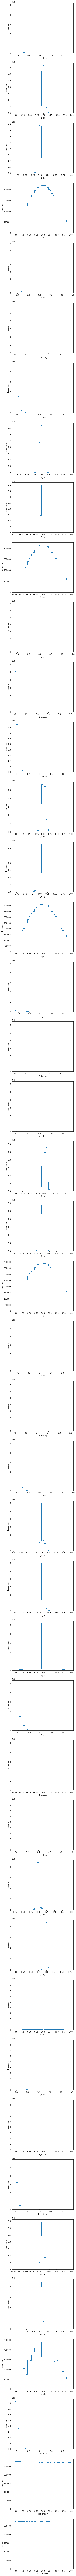

In [6]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

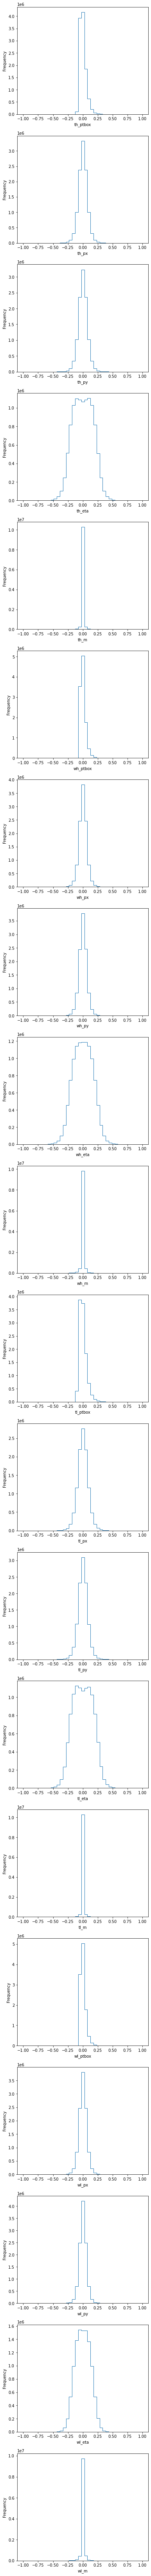

In [7]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Build the Model

In [8]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(len(Y_names)//2)(ldense2)
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(len(Y_names)//2)(hdense2)
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    # Define loss function
    def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 6)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 43)           0           ['input_2[0][0]',                
                                                                  'flatten[0][0]']            

2022-04-14 15:09:15.636676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-04-14 15:09:15.636696: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-14 15:09:15.637318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

## Fit the Model 

In [12]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([valX_jets, valX_other], valY), shuffle=True, callbacks=[early_stop],
                    batch_size=1000)
#history = model.fit([totalX_jets, totalX_other], Y_total, verbose=1, epochs=Epochs,
#                   validation_split=0.1, shuffle=True, callbacks=[early_stop],
#                    batch_size=1000)

2022-04-14 15:30:21.192984: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1109669184 exceeds 10% of free system memory.


Epoch 1/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0212 - mse: 0.0015 - val_loss: 0.0212 - val_mse: 0.0015
Epoch 2/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0211 - mse: 0.0015 - val_loss: 0.0212 - val_mse: 0.0015
Epoch 3/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0210 - mse: 0.0015 - val_loss: 0.0211 - val_mse: 0.0015
Epoch 4/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0210 - mse: 0.0015 - val_loss: 0.0211 - val_mse: 0.0015
Epoch 5/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0209 - mse: 0.0015 - val_loss: 0.0210 - val_mse: 0.0015
Epoch 6/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0209 - mse: 0.0015 - val_loss: 0.0210 - val_mse: 0.0015
Epoch 7/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0209 - mse: 0.0015 - val_loss: 0.0210 - val_mse: 0.0015
Epoch 8/256
7707/7707 [===========

7707/7707 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0205 - val_mse: 0.0015
Epoch 61/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 62/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0205 - val_mse: 0.0015
Epoch 63/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 64/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0205 - val_mse: 0.0015
Epoch 65/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 66/256
7707/7707 [==============================] - 121s 16ms/step - loss: 0.0201 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 67/256
7707/7707 [================

## Save the Model

In [13]:
model.save('model_e+mjets.keras')

## Plot Training Stats 

In [ ]:
#plt.xlabel('Training Iterations')
#plt.ylabel('Learning Rate')
#plt.title("CLR - 'triangular' Policy")
#plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'MSE loss')

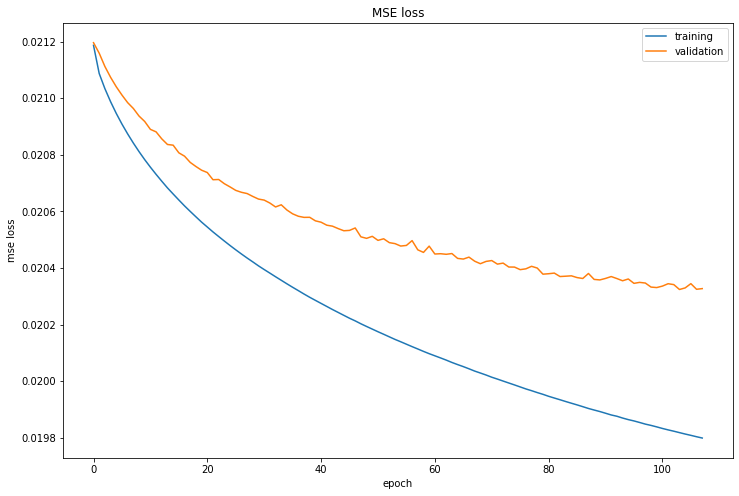

In [14]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

# Testing and Plots

This part of the code tests the machine learning and data.

## Make Predictions with Test Data

In [15]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)

## Calculate the Other Variables We Want

In [16]:
from observables import norm, cross, dot
from transform import Transform

# We're going to turn this into dictionaries for easier reading
truths = {Y_keys[i] : true_origscale[:,i].reshape((-1,1)) for i in range(len(Y_keys))}
preds = {Y_keys[i] : predictions_origscale[:,i].reshape((-1,1)) for i in range(len(Y_keys))}

for var in [truths,preds]:
    
    # Calculate momentum components (for later calculations)
    th_px, th_py, th_pz = Transform.polar_to_cart(var['th_pt'],var['th_eta'],var['th_phi'])
    tl_px, tl_py, tl_pz = Transform.polar_to_cart(var['tl_pt'],var['tl_eta'],var['tl_phi'])
    
    # Calculate total momentums of the had and lep tops
    th_p = np.sqrt(th_px**2 + th_py**2 + th_pz**2) 
    tl_p = np.sqrt(tl_px**2 + tl_py**2 + tl_pz**2)
    
    # Calculate had and lep momenum vectors
    th_P = np.concatenate([th_px, th_py, th_pz], axis=1)  # concatenates values from the same event into one array
    tl_P = np.concatenate([tl_px, tl_py, tl_pz], axis=1)
    
    # Calculate momenum vector of ttbar?
    top_P = th_P + tl_P
    
    # Calculate energies of had and lep top
    th_E, tl_E = np.sqrt(var['th_m']**2+th_p**2), np.sqrt(var['tl_m']**2 + th_p**2)
    
    # Calculate energy of ttbar? and put into dict
    top_E = th_E + tl_E
    var['ttbar_E'] = top_E
    
    # Calculate had and lep pout and put into dict
    ez = np.repeat(np.array([[0,0,1]]), var['th_eta'].shape[0],axis=0)
    var['th_pout'] = dot(th_P, cross(tl_P,ez)/norm(cross(tl_P,ez)))
    var['tl_pout'] = dot(tl_P, cross(th_P,ez)/norm(cross(tl_P,ez)))
    
    # Calculate ttbar_Ht? and put into dict
    var['ttbar_Ht'] = var['th_pt']+var['tl_pt']
    
    # Put had and lep energies into the dict
    var['th_E'] = th_E
    var['tl_E'] = tl_E
    
    # Calculate ttbar_dphi and put into the dict
    var['ttbar_dphi'] = np.abs(var['th_phi']-var['tl_phi'])
    
    # Calculate ttbar_m and put into the dict (not 100% about the square root)
    var['ttbar_m'] = np.sqrt(top_E**2 - norm(top_P)**2)
    
    
    # Calculate had and lep y (this is Jenna's attempt, using eq from wikipedia) (could also try using vector)
    var['th_y'] = np.log((np.sqrt(var['th_m']**2+var['th_pt']**2*np.cosh(var['th_eta'])**2)+var['th_pt']*np.sinh(var['th_eta']))/np.sqrt(var['th_m']**2+var['th_pt']**2))
    var['tl_y'] = np.log((np.sqrt(var['tl_m']**2+var['tl_pt']**2*np.cosh(var['tl_eta'])**2)+var['tl_pt']*np.sinh(var['tl_eta']))/np.sqrt(var['tl_m']**2+var['tl_pt']**2))

    # Calculate ttbar_yboost and y*
    var['ttbar_yboost'] = 0.5*(var['th_y']+var['tl_y'])
    var['ttbar_ystar'] = 0.5*(var['th_y']-var['tl_y'])
    
    # Calculate eta and phi for ttabr
    top_pt, top_eta, top_phi = Transform.cart_to_polar(top_P[:,0],top_P[:,1],top_P[:,2])
    var['ttbar_pt'] = top_pt
    var['ttbar_eta'] = top_eta
    var['ttbar_phi'] = top_phi
    
# Save as a tree root file
import uproot
final_keys = list(preds.keys())
results_file = uproot.recreate('ML_Results.root')
results_file["reco"] = {final_keys[i]:preds[final_keys[i]].flatten() for i in range(len(final_keys))}
results_file["parton"] = {final_keys[i]:truths[final_keys[i]].flatten() for i in range(len(final_keys))}

/tmp/ipykernel_3035305/1605377835.py:48: RuntimeWarning: invalid value encountered in sqrt
  var['ttbar_m'] = np.sqrt(top_E**2 - norm(top_P)**2)


/tmp/ipykernel_3035305/2344375906.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(col)


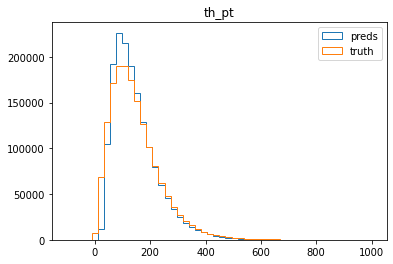

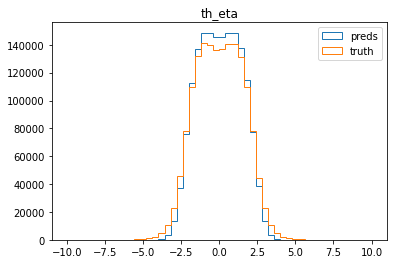

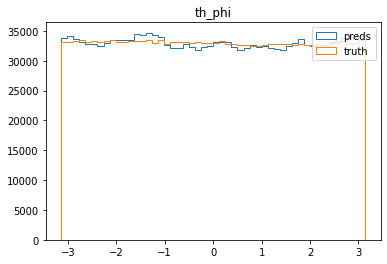

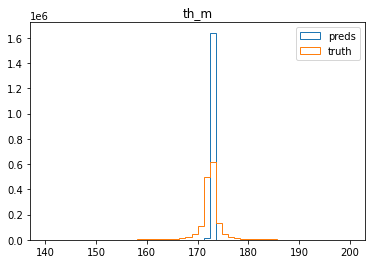

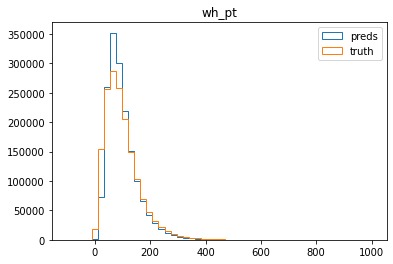

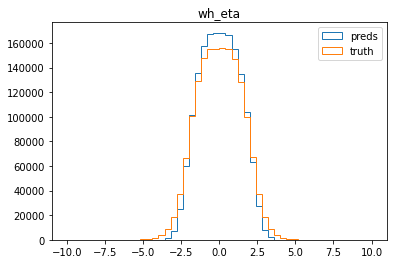

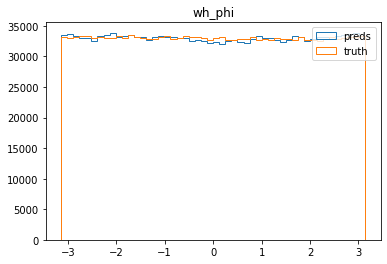

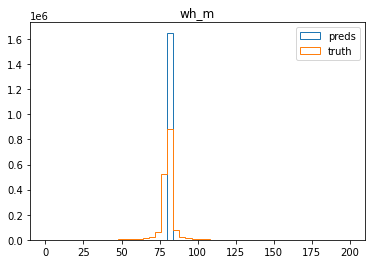

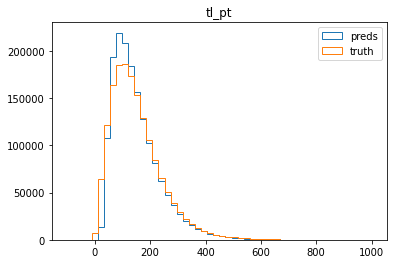

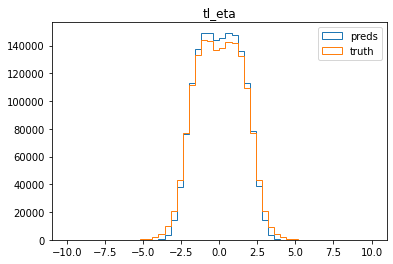

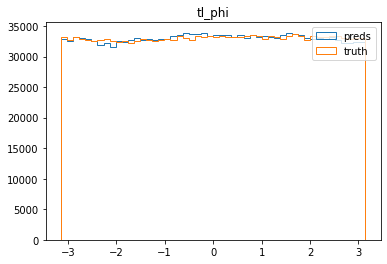

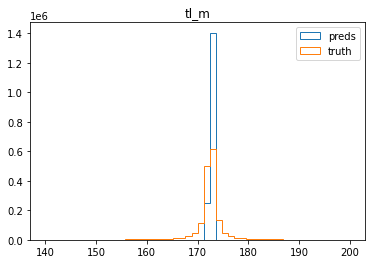

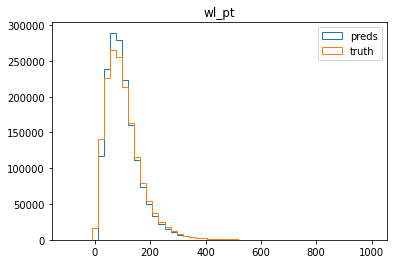

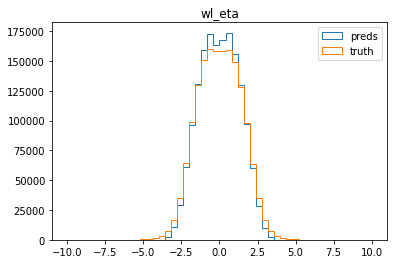

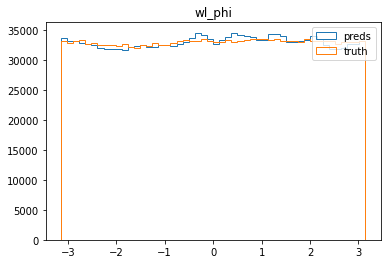

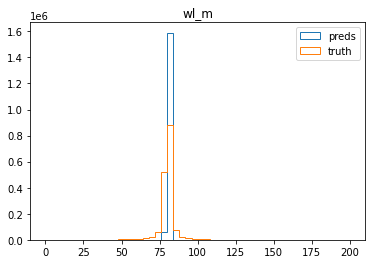

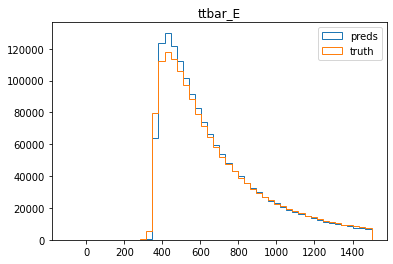

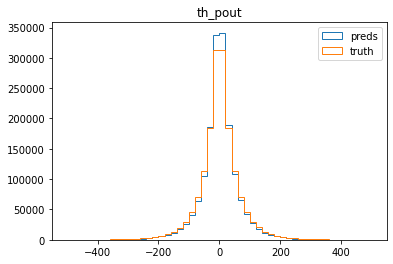

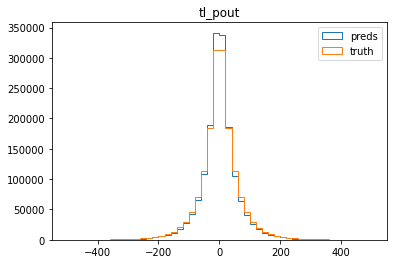

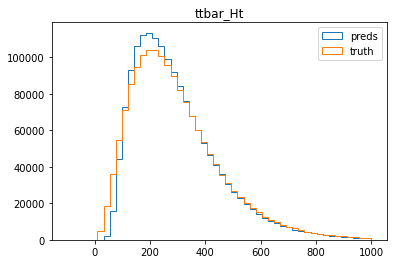

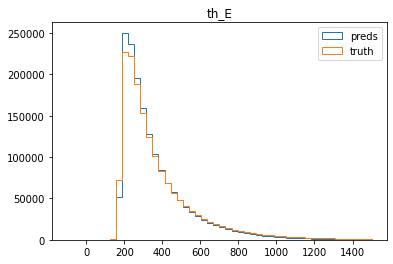

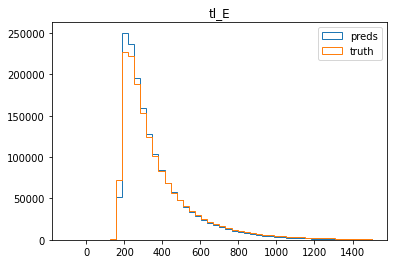

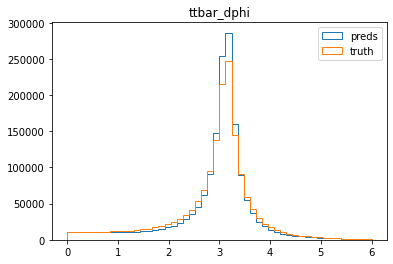

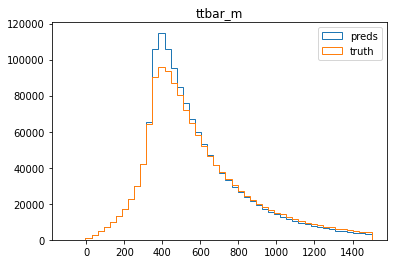

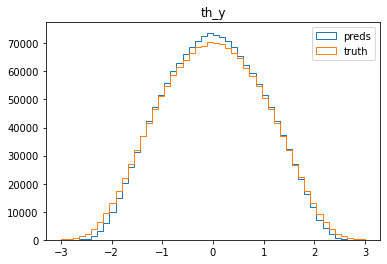

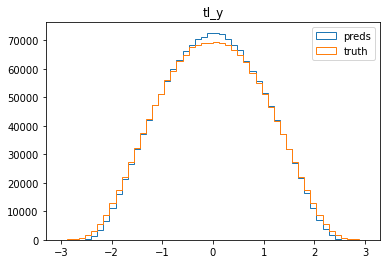

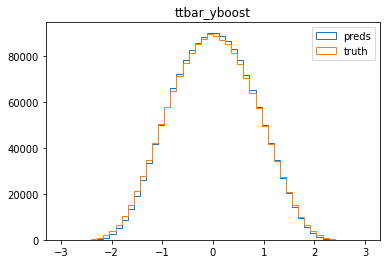

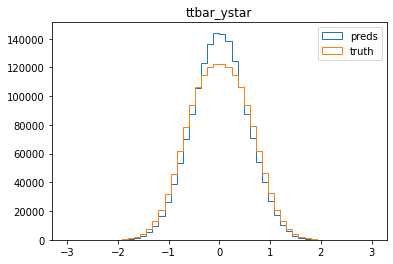

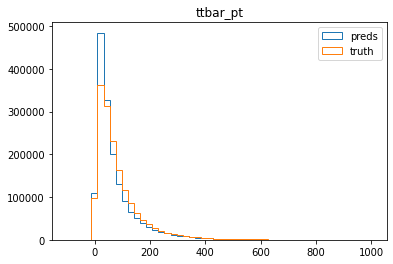

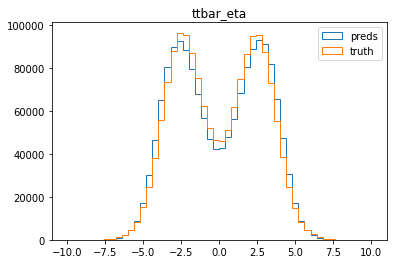

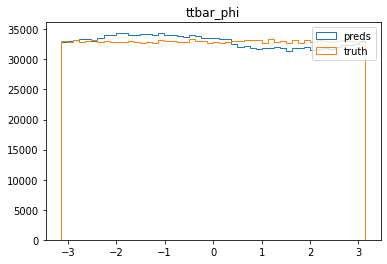

In [17]:
for col in truths:
    
    if col in ['th_pt','tl_pt','wh_pt','wl_pt','ttbar_pt','ttbar_Ht']:
        r = (-100,1000)
    elif col in ['th_E','tl_E','ttbar_E','ttbar_m']:
        r = (-100,1500)
    elif col in ['th_eta','tl_eta','wh_eta','wl_eta','ttbar_eta']:
        r = (-10,10)
    elif col in ['th_phi','tl_phi','wh_phi','wl_phi','ttbar_phi']:
        r = (-3.14,3.14)
    elif col in ['th_pout','tl_pout','ttbar_pout']:
        r = (-500,500)
    elif col in ['th_m','tl_m']:
        r = (140,200)
    elif col in ['wh_m','wl_m']:
        r = (0,200)
    elif col in ['ttbar_m']:
        r = (0,1500)
    elif col in ['th_y','tl_y','ttbar_yboost','ttbar_ystar']:
        r = (-3,3)
    elif col in ['ttbar_dphi']:
        r = (0,6)
    else:
        r = (0,7)

    
    # Create
    plt.figure(col)
    
    # Plot new data
    plt.title(col)
    plt.hist(preds[col],bins=50,range=r,histtype='step')
    plt.hist(truths[col],bins=50,range=r,histtype='step')
    plt.legend(['preds','truth'])

## Training Scale Plots (Tao's Code)

In [18]:
import analysis

Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.001495082051261046
 
th_ptbox MSE, MAE :  0.0006184581 0.0165899505
th_px MSE, MAE :  0.0012120301 0.0206996715
th_py MSE, MAE :  0.0012848434 0.0212853701
th_eta MSE, MAE :  0.0055049531 0.0407906994
th_m MSE, MAE :  0.0005948790 0.0087240065
wh_ptbox MSE, MAE :  0.0006720801 0.0163005899
wh_px MSE, MAE :  0.0011678774 0.0202582008
wh_py MSE, MAE :  0.0012008408 0.0204764537
wh_eta MSE, MAE :  0.0067225399 0.0460232753
wh_m MSE, MAE :  0.0007999249 0.0123276151
tl_ptbox MSE, MAE :  0.0005069621 0.0160709097
tl_px MSE, MAE :  0.0008193195 0.0191989480
tl_py MSE, MAE :  0.0006468352 0.0170844177
tl_eta MSE, MAE :  0.0035428764 0.0391206826
tl_m MSE, MAE :  0.0006032124 0.0087571747
wl_ptbox MSE, MAE :  0.0002832910 0.0123613324
wl_px MSE, MAE :  0.0002947036 0.0126954097
wl_py MSE, MAE :  0.0002383123 0.0114122452
wl_eta MSE, MAE :  0.0022537783 0.0334272265
wl_m MSE, MAE :  0.0009339235 0.0132907844


In [19]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 323.85075372656917
 
th_pt MSE, MAE :  1814.5925359678 28.4170846198
th_eta MSE, MAE :  0.4621663909 0.3737519956
th_phi MSE, MAE :  0.6820707387 0.4500471333
th_m MSE, MAE :  35.4025157194 2.1282308202
wh_pt MSE, MAE :  1350.2513675662 23.1046883864
wh_eta MSE, MAE :  0.5343649497 0.4103267317
wh_phi MSE, MAE :  0.6490287244 0.4519937061
wh_m MSE, MAE :  36.2652955326 2.6248232231
tl_pt MSE, MAE :  1239.1445844332 25.1254411694
tl_eta MSE, MAE :  0.2942111892 0.3564987557
tl_phi MSE, MAE :  0.4062291988 0.3360185536
tl_m MSE, MAE :  35.8980678957 2.1363107479
wl_pt MSE, MAE :  623.8645301936 18.3439990942
wl_eta MSE, MAE :  0.2876660053 0.3776495889
wl_phi MSE, MAE :  0.1853927330 0.2416013082
wl_m MSE, MAE :  37.2213703502 2.6533292835


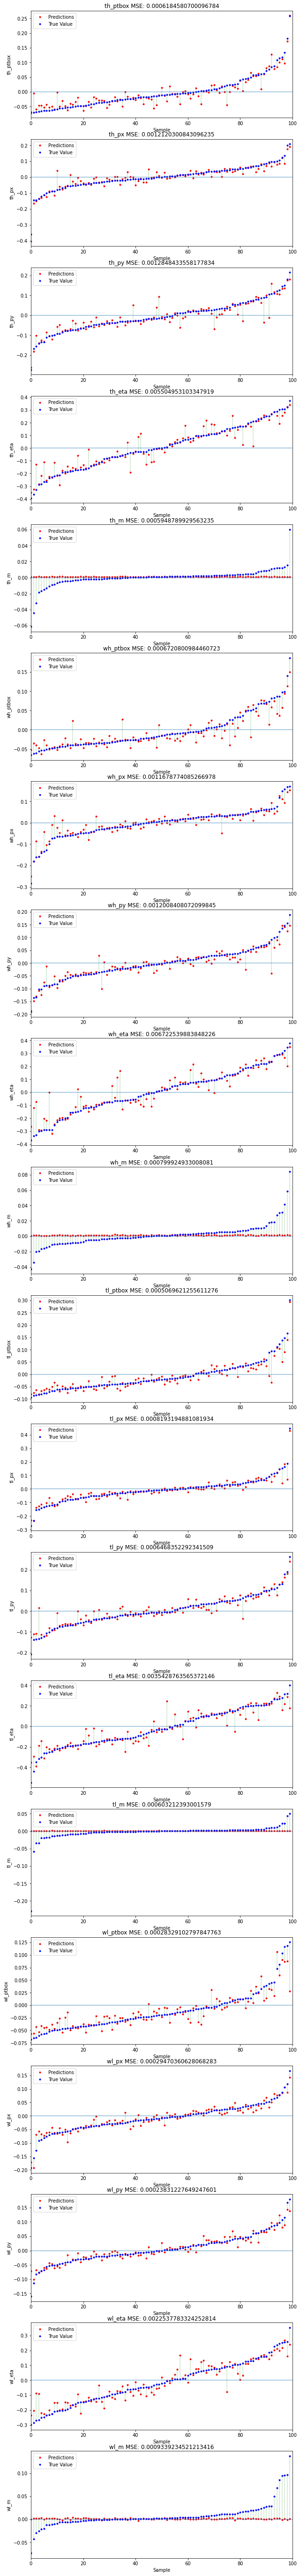

In [20]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

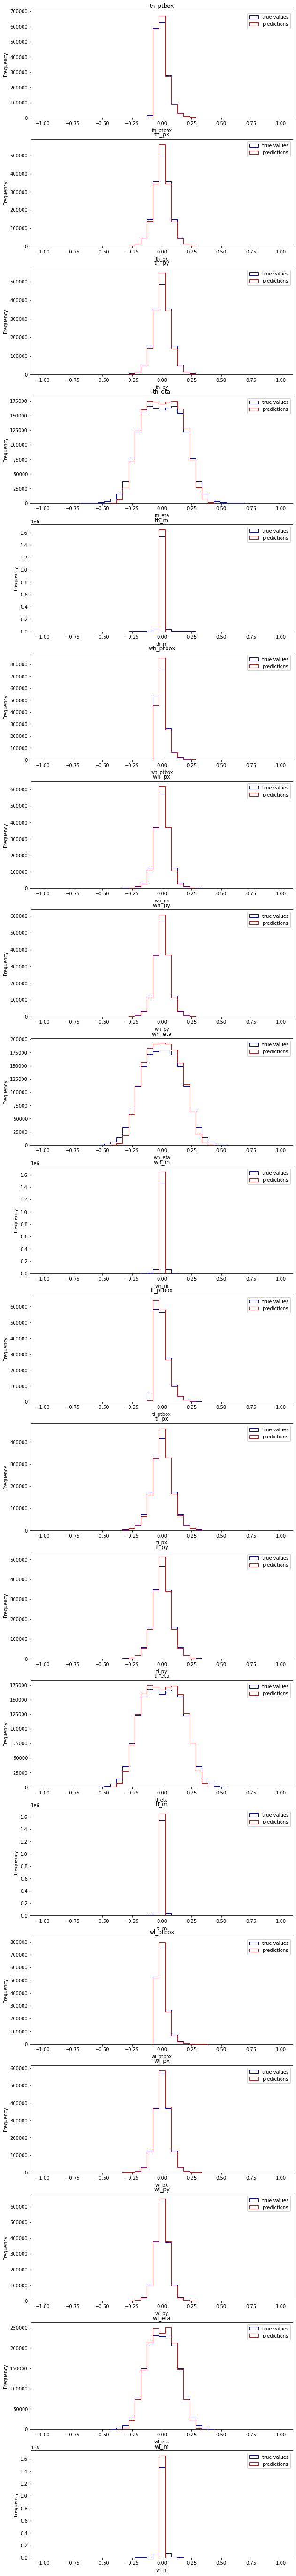

In [21]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

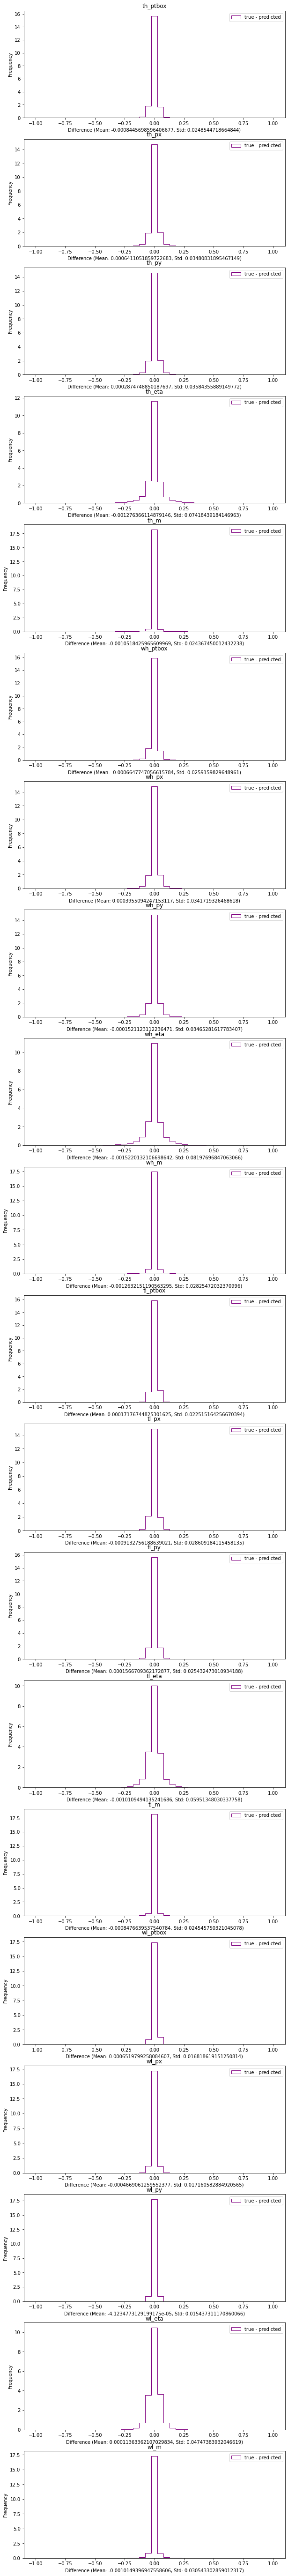

In [22]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

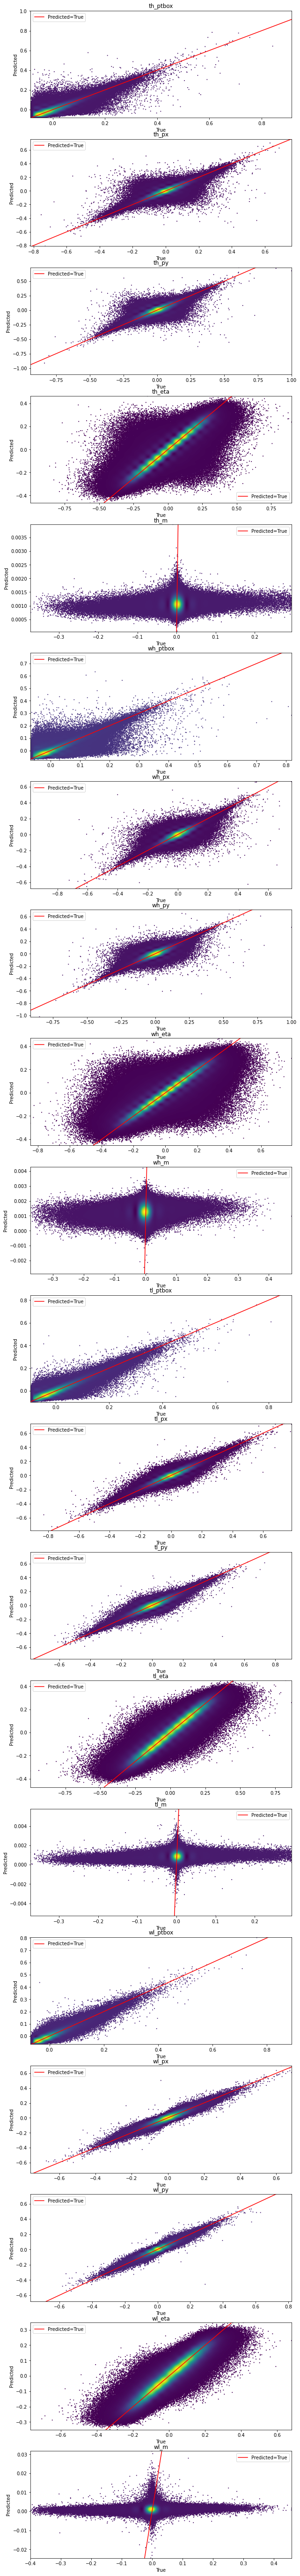

In [23]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [24]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 323.85075372656917
 
th_pt MSE, MAE :  1814.5925359678 28.4170846198
th_eta MSE, MAE :  0.4621663909 0.3737519956
th_phi MSE, MAE :  0.6820707387 0.4500471333
th_m MSE, MAE :  35.4025157194 2.1282308202
wh_pt MSE, MAE :  1350.2513675662 23.1046883864
wh_eta MSE, MAE :  0.5343649497 0.4103267317
wh_phi MSE, MAE :  0.6490287244 0.4519937061
wh_m MSE, MAE :  36.2652955326 2.6248232231
tl_pt MSE, MAE :  1239.1445844332 25.1254411694
tl_eta MSE, MAE :  0.2942111892 0.3564987557
tl_phi MSE, MAE :  0.4062291988 0.3360185536
tl_m MSE, MAE :  35.8980678957 2.1363107479
wl_pt MSE, MAE :  623.8645301936 18.3439990942
wl_eta MSE, MAE :  0.2876660053 0.3776495889
wl_phi MSE, MAE :  0.1853927330 0.2416013082
wl_m MSE, MAE :  37.2213703502 2.6533292835


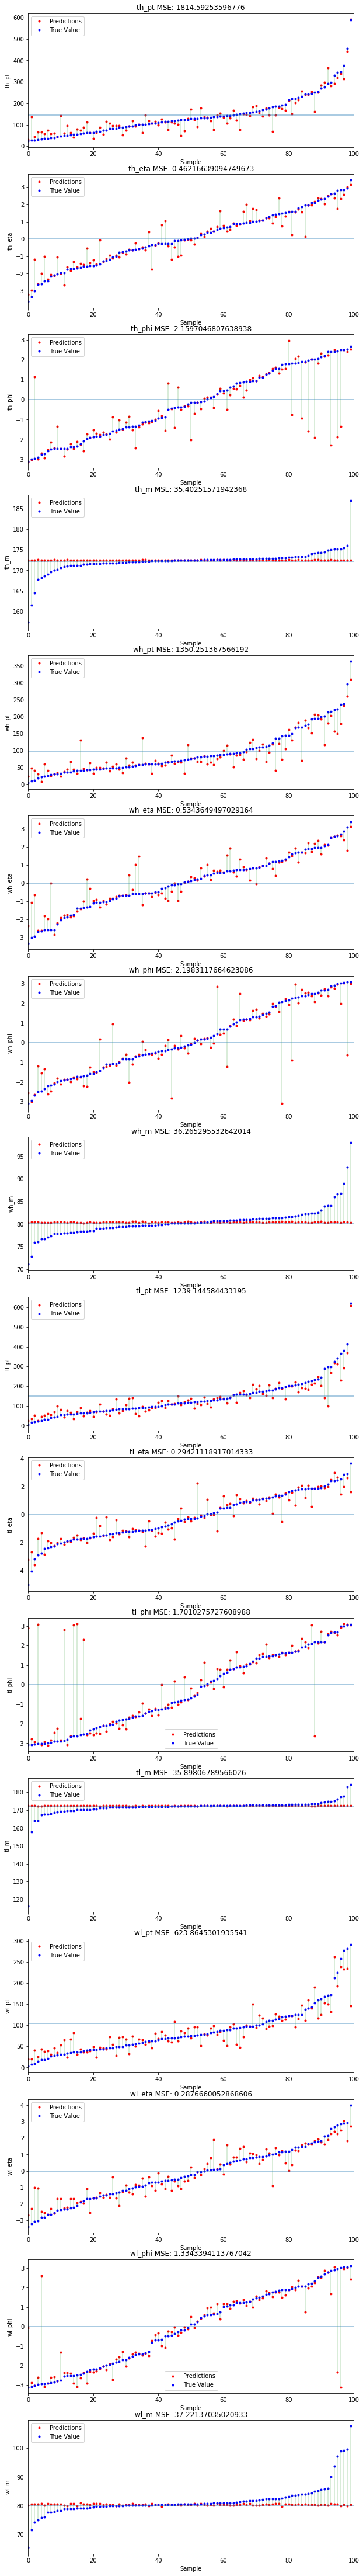

In [25]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

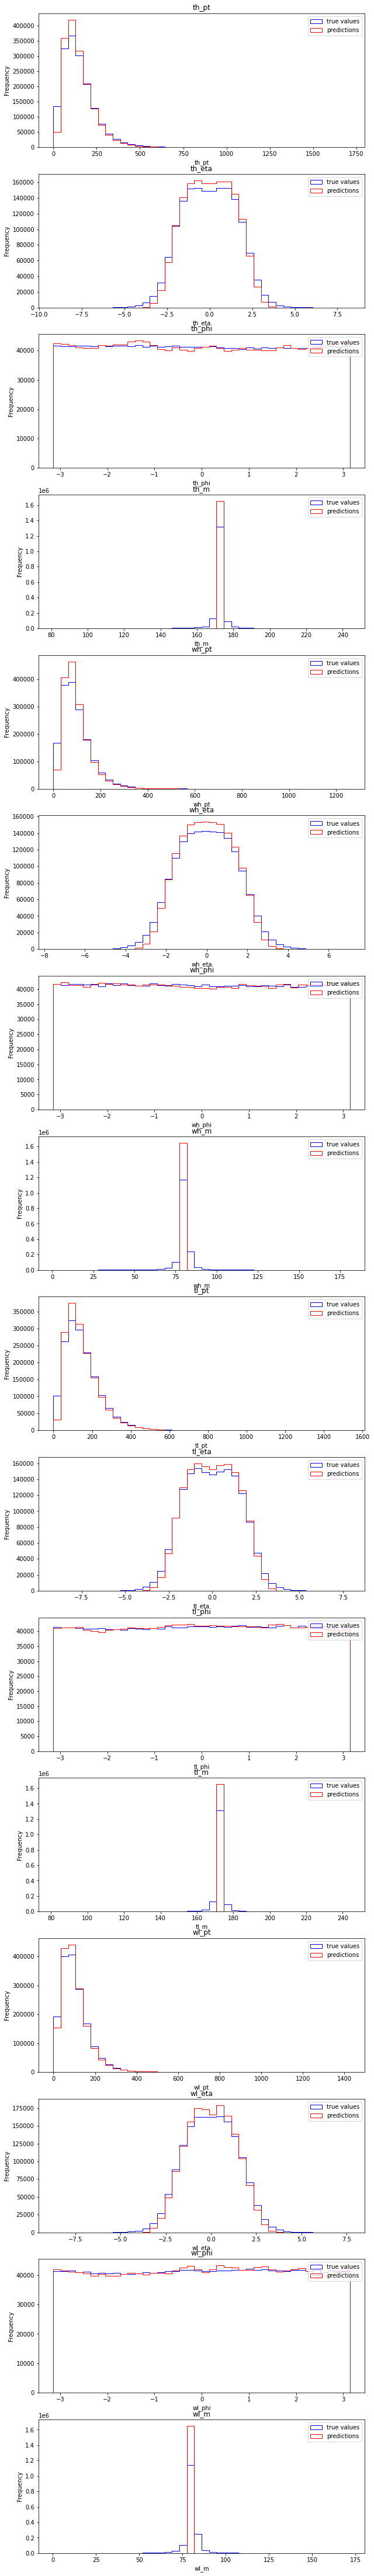

In [26]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

/home/jchishol/myVenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


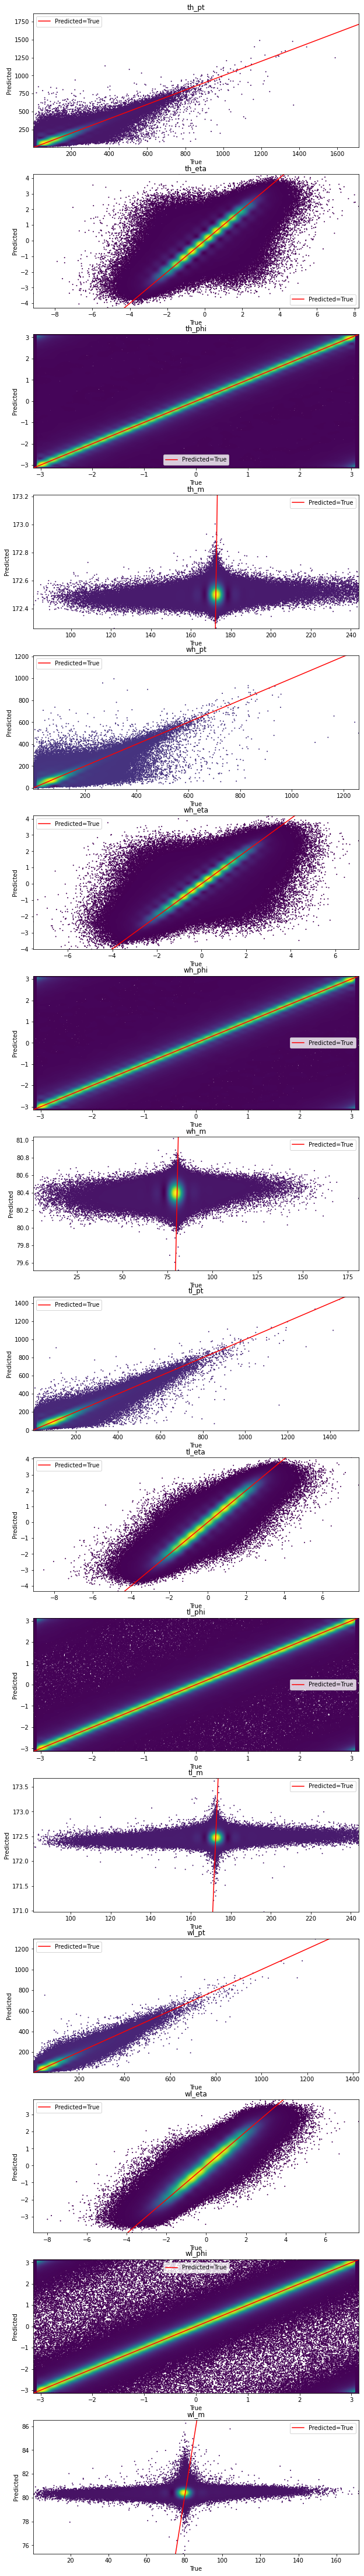

In [27]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

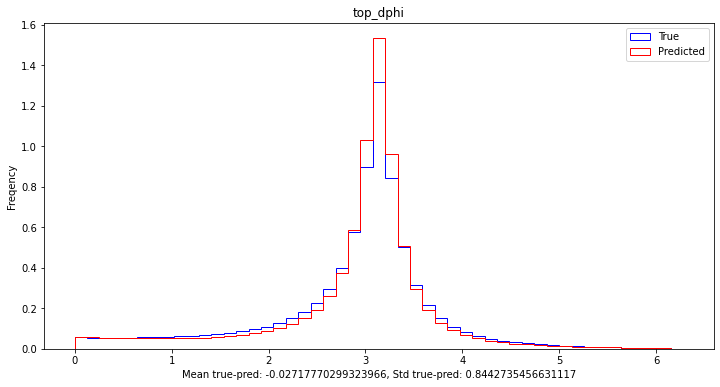

In [28]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

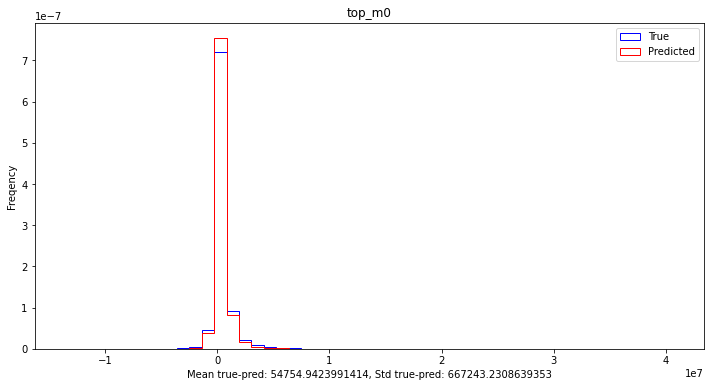

In [29]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

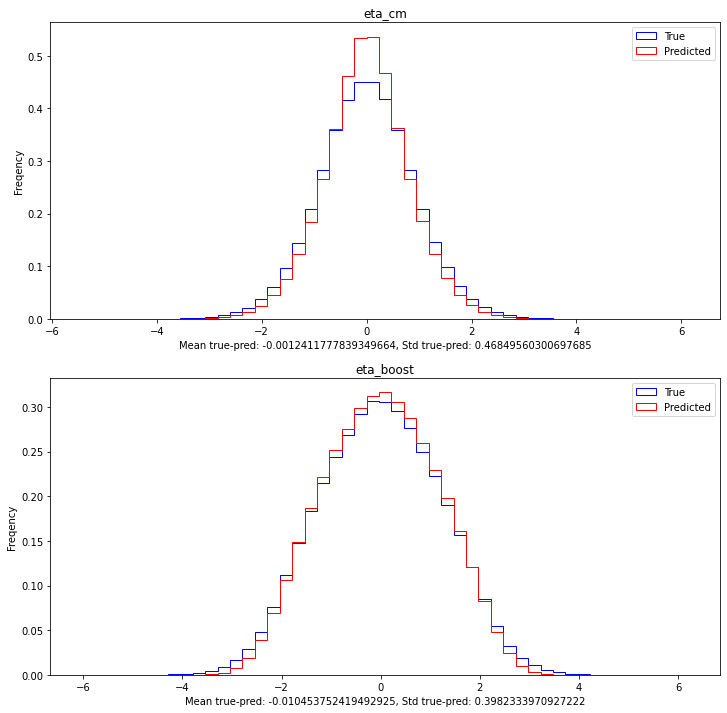

In [30]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

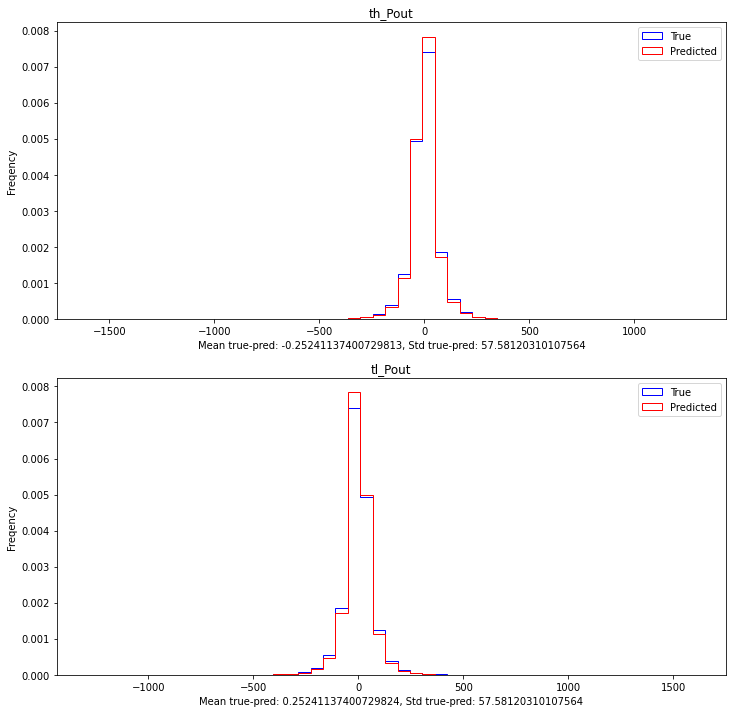

In [31]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

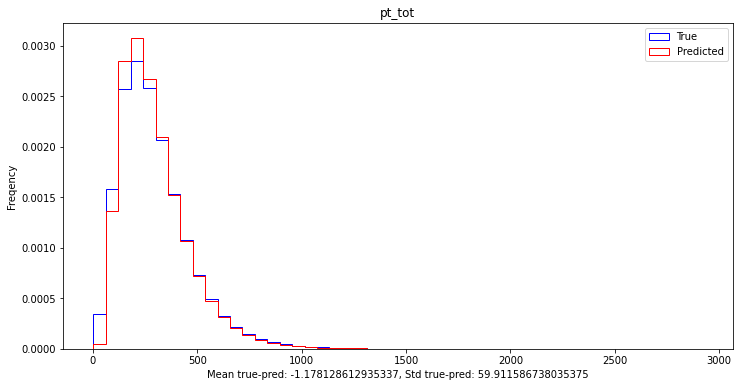

In [32]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])